# 1. Configuration

## 1-1. Import

In [1]:
import cv2
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from glob import glob
from copy import deepcopy

## 1-2. Dir

In [2]:
DATA_DIR = "/home/pervinco/Datasets/BKAI_IGH_NeoPolyp"
IMG_DIR = f"{DATA_DIR}/train/train"
GT_DIR = f"{DATA_DIR}/train_gt/train_gt"
TEST_DIR = f"{DATA_DIR}/test/test"

In [3]:
images = sorted(glob(f"{IMG_DIR}/*.jpeg"))
labels = sorted(glob(f"{GT_DIR}/*.jpeg"))

print(len(images), len(labels))

1000 1000


# 2. Sample visualize

## 2-1. Choice single sample

In [4]:
idx = random.randint(0, len(images))
sample_image_file, sample_label_file = images[idx], labels[idx]

(995, 1280, 3) (995, 1280, 3)


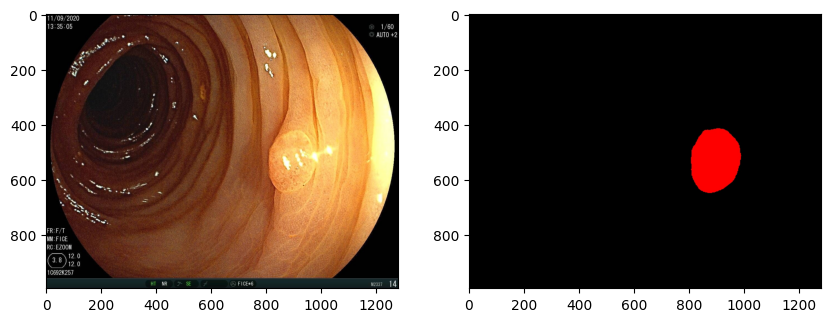

In [5]:
sample_image = cv2.imread(sample_image_file)
sample_image = cv2.cvtColor(sample_image, cv2.COLOR_BGR2RGB)

sample_label = cv2.imread(sample_label_file)
sample_label = cv2.cvtColor(sample_label, cv2.COLOR_BGR2RGB)

print(sample_image.shape, sample_label.shape)
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.imshow(sample_image)

plt.subplot(1, 2, 2)
plt.imshow(sample_label)

## 2-2. Overlay(image + mask)

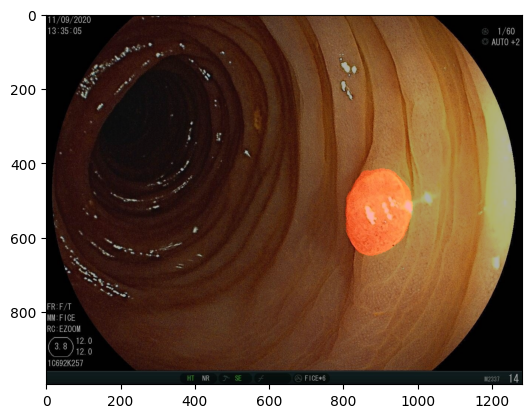

In [6]:
alpha = 0.7
beta = 0.3

overlayed = cv2.addWeighted(sample_image, alpha, sample_label, beta, 0)

plt.imshow(overlayed)

## 2-3. Mask data analysis

In [7]:
copy_label = deepcopy(sample_label)

데이터 구성에는 Red, Green, Black으로 구성되어 있다고 하지만 마스크 값을 보면 아래와 다르다.
- Red color: neoplastic polyps [255, 0, 0]
- Green color: non-neoplastic polyps [0, 255, 0]
- Black color: background, [0, 0, 0]

In [8]:
# non_background_pixels = copy_label[np.any(copy_label != [0, 0, 0], axis=-1)] # 모든 픽셀 중에서 검은색을 제외한 픽셀만 선택

# unique_pixels = np.unique(non_background_pixels, axis=0) # 유일한 픽셀 값 파악
# print(len(unique_pixels))

# with open("./single_mask.txt", "w") as f:
#     for pixel in unique_pixels:
#         f.write(f"{pixel}\n")

검은색 픽셀[0, 0, 0]을 제외한, 유의미한 픽셀 전체를 사용해 마스크를 생성해보면 ground-truth 보다 noise가 추가되어 있는 것을 볼 수 있다.

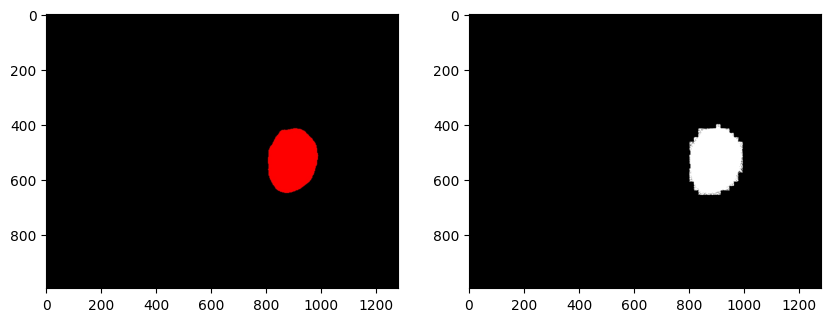

In [9]:
mask = np.any(copy_label != [0, 0, 0], axis=-1)
copy_label[mask] = [255, 255, 255]

plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.imshow(sample_label)

plt.subplot(1, 2, 2)
plt.imshow(copy_label)

single_mask.txt를 살펴봤을 때 Red 또는 Green 값이 100이상의 값들임을 확인할 수 있다.

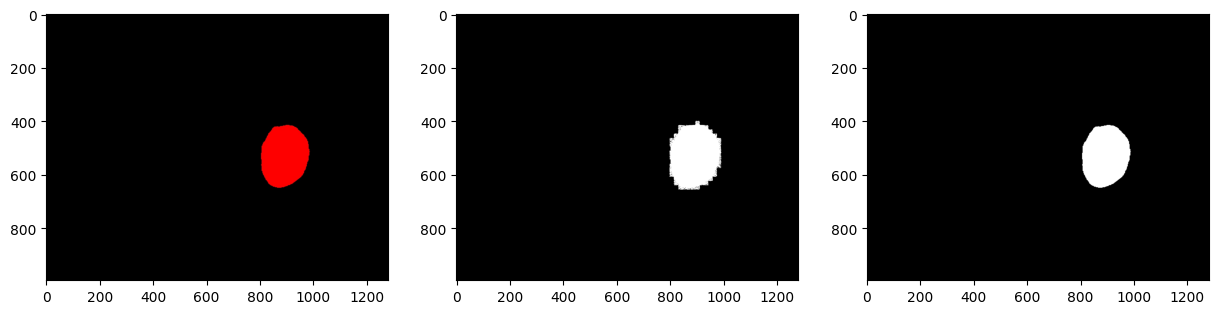

In [10]:
red_mask = sample_label[:, :, 0] >= 100
green_mask = sample_label[:, :, 1] >= 100

# 두 조건 중 하나라도 만족하는 픽셀 합치기
combined_mask = np.logical_or(red_mask, green_mask)

# 조건을 만족하는 픽셀을 흰색으로 표시
result_image = np.zeros_like(sample_label)
result_image[combined_mask] = [255, 255, 255]

plt.figure(figsize=(15, 8))

plt.subplot(1, 3, 1)
plt.imshow(sample_label)

plt.subplot(1, 3, 2)
plt.imshow(copy_label)

plt.subplot(1, 3, 3)
plt.imshow(result_image)

# 3. Dataset Analysis

## 3-1. image per mask

데이터셋에 포함된 mask 이미지의 픽셀들의 총량을 파악.

[57663478, 8413571, 1192086328]


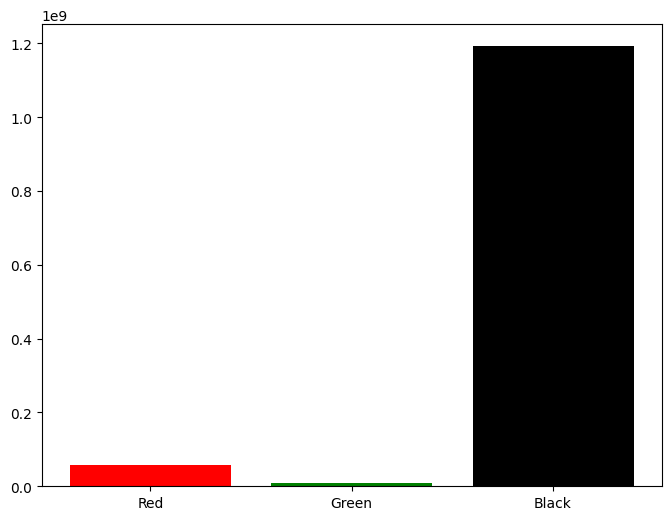

In [11]:
data = []
total_red, total_green, total_black = 0, 0, 0
for label_file in labels:
    file_name = label_file.split('/')[-1].split('.')[0]
    red_count, green_count = 0, 0

    sample_label = cv2.imread(label_file)
    sample_label = cv2.cvtColor(sample_label, cv2.COLOR_BGR2RGB)
    
    red_mask = sample_label[:, :, 0] >= 100
    green_mask = sample_label[:, :, 1] >= 100
    black_mask = ~red_mask & ~green_mask

    red_count = np.sum(red_mask)
    green_count = np.sum(green_mask)
    black_count = np.sum(black_mask)

    total_red += red_count
    total_green += green_count
    total_black += black_count

    data.append({
        'image_file': file_name,
        'red_count': red_count,
        'green_count': green_count,
        'black_count': black_count
    })

# df = pd.DataFrame(data)
# csv_path = './pixel_counts.csv'
# df.to_csv(csv_path, index=False)

plot_labels = ['Red', 'Green', 'Black']
plot_values = [total_red, total_green, total_black]
plot_colors = ['red', 'green', 'black']

print(plot_values)
plt.figure(figsize=(8,6))
plt.bar(plot_labels, plot_values, color=plot_colors)
plt.show()

csv 파일 내용을 분석한 결과 하나의 이미지에 red, green이 동시에 존재하는 이미지도 존재함을 확인.

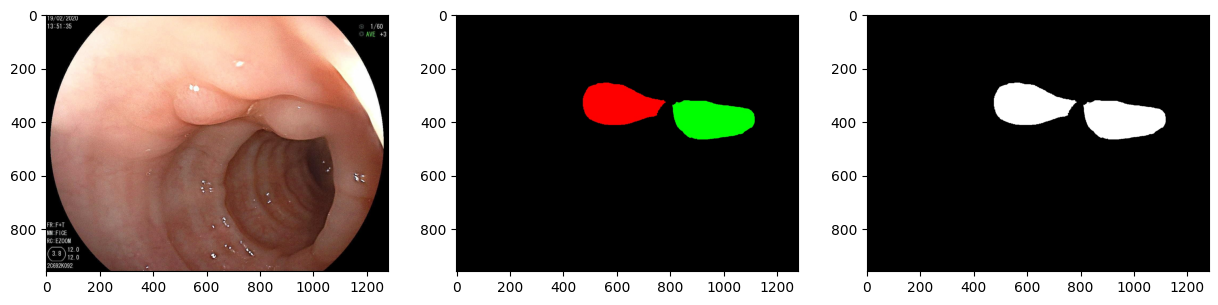

In [12]:
image1, label1 = images[107], labels[107]

image1 = cv2.imread(image1)
image1 = cv2.cvtColor(image1, cv2.COLOR_BGR2RGB)

label1 = cv2.imread(label1)
label1 = cv2.cvtColor(label1, cv2.COLOR_BGR2RGB)

red_mask = label1[:, :, 0] >= 100
green_mask = label1[:, :, 1] >= 100

combined_mask = np.logical_or(red_mask, green_mask)
result_image = np.zeros_like(label1)
result_image[combined_mask] = [255, 255, 255]

plt.figure(figsize=(15, 8))

plt.subplot(1, 3, 1)
plt.imshow(image1)

plt.subplot(1, 3, 2)
plt.imshow(label1)

plt.subplot(1, 3, 3)
plt.imshow(result_image)

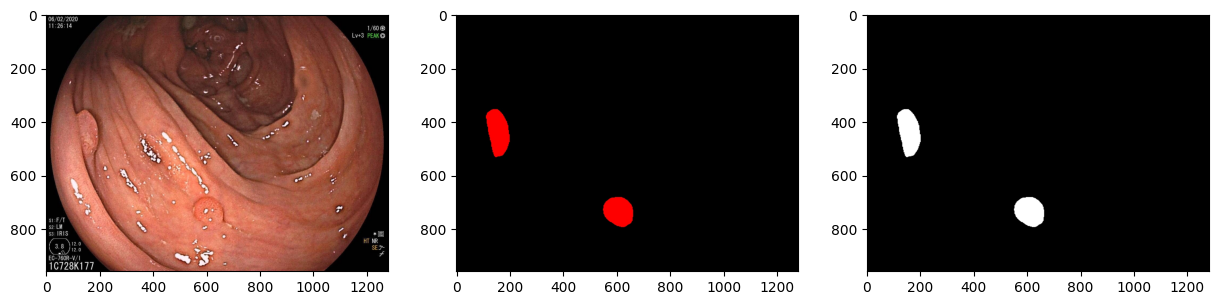

In [13]:
image2, label2 = images[97], labels[97]

image2 = cv2.imread(image2)
image2 = cv2.cvtColor(image2, cv2.COLOR_BGR2RGB)

label2 = cv2.imread(label2)
label2 = cv2.cvtColor(label2, cv2.COLOR_BGR2RGB)

red_mask = label2[:, :, 0] >= 100
green_mask = label2[:, :, 1] >= 100

combined_mask = np.logical_or(red_mask, green_mask)
result_image = np.zeros_like(label2)
result_image[combined_mask] = [255, 255, 255]

plt.figure(figsize=(15, 8))

plt.subplot(1, 3, 1)
plt.imshow(image2)

plt.subplot(1, 3, 2)
plt.imshow(label2)

plt.subplot(1, 3, 3)
plt.imshow(result_image)

## 3-2. Mask Preprocessing

[www.kaggle.com/competitions/bkai-igh-neopolyp/overview/evaluation](www.kaggle.com/competitions/bkai-igh-neopolyp/overview/evaluation)

    This competition is evaluated on the mean Dice coefficient. The Dice coefficient can be used to compare the pixel-wise agreement between a predicted segmentation and its corresponding ground truth. The formula is given by: $2∗|𝑋∩𝑌| \ |𝑋|+|𝑌|$
    where X is the predicted set of pixels and Y is the ground truth. The Dice coefficient is defined to be 1 when both X and Y are empty. The leaderboard score is the mean of the Dice coefficients for each pair in the test set. ClassId = 0 means neoplastic polyp, while ClassId = 1 means non-neoplastic polyp.

평가 기준을 보면 Mean Dice coefficient를 통해 y_pred(mask)와 y_true(mask)간 일종의 IoU를 계산하며, 픽셀 값들은 0(neoplastic polyp), 1(non-neoplastic polyp)으로 mapping된다고 한다.  
따라서 ground-truth mask 이미지에서 Red 또는 Green 채널의 값이 100이상인 픽셀을 각각 0, 1로 mapping하고, background는 2로 mapping.

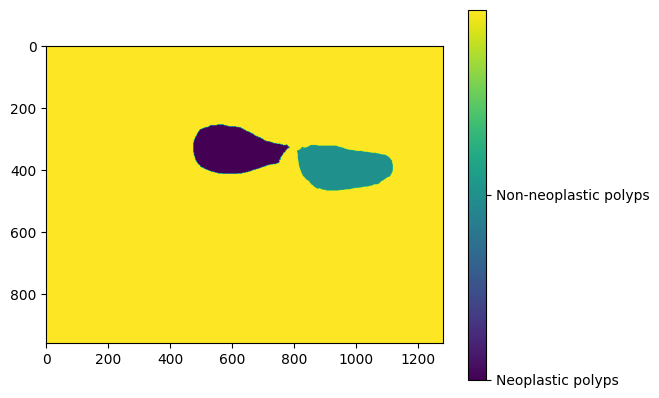

In [14]:
# sample_idx = random.randint(0, len(images)-1)
sample_idx = 107

image2 = cv2.imread(images[sample_idx])
image2 = cv2.cvtColor(image2, cv2.COLOR_BGR2RGB)

label2 = cv2.imread(labels[sample_idx])
label2 = cv2.cvtColor(label2, cv2.COLOR_BGR2RGB)

label_transformed = np.full(label2.shape[:2], 2, dtype=np.uint8)  # 초기 마스크를 2(background)로 설정

# Red color (neoplastic polyps)를 0으로 변환
red_mask = (label2[:, :, 0] > 100) & (label2[:, :, 1] < 100) & (label2[:, :, 2] < 100)
label_transformed[red_mask] = 0

# Green color (non-neoplastic polyps)를 1로 변환
green_mask = (label2[:, :, 0] < 100) & (label2[:, :, 1] > 100) & (label2[:, :, 2] < 100)
label_transformed[green_mask] = 1

im = plt.imshow(label_transformed)
cbar = plt.colorbar(im)
cbar.set_ticks([0, 1])
cbar.set_ticklabels(['Neoplastic polyps', 'Non-neoplastic polyps'])

plt.show()


# 4. Caution

## 4.1 Submission Expected

아래 두 가지 방식을 통해 expected column에 기입될 값의 형태를 명시. 참조 코드 [https://github.com/sangdv/rle_encode/blob/main/mask2csv.py](https://github.com/sangdv/rle_encode/blob/main/mask2csv.py)
1. run-length encoding
2. space-delimited list of pairs. 

    Id,Expected  
    633a8d5b2b2b55157b7781e2c706c75c_0, 200 10    
    633a8d5b2b2b55157b7781e2c706c75c_1, 500 11    
  
    etc...


같은 이미지에 대해 두 번의 추론을 진행해서 Neoplastic polyp(0)의 mask영역과 Non-neoplastic polyp(1)의 mask 영역을 run-length encoding 방식으로 기입.
- For example, '1 3 10 5' implies pixels 1,2,3,10,11,12,13,14 are to be included in the mask.  
- 1, 3, 10, 5라고 기재하면 1번 픽셀부터 3step인 1, 2, 3 그리고 10번 픽셀부터 5step인 10, 11, 12, 13, 14
- 간단히 말해 row-wise로 [첫번째 mask pixel, steps] 형태로 기입할 것.


## 4.2 Submission Mask Size

    Important Note  
    It should be emphasized that the predicted segmentation results must match the size of the original image. Therefore, if you resize the input image to fit your models, you must also resize the prediction output back to the original size of the input image before converting it to the required format.

model의 출력 mask는 resize된 크기이므로 원본의 크기로 되돌린 다음, mask영역을 run-length encoding 포맷으로 작성할 것.

In [15]:
test_img_files = sorted(glob(f"{TEST_DIR}/*.jpeg"))
print(len(test_img_files))

sizes = []
for file in test_img_files:
    image = cv2.imread(file)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    if not image.shape in sizes:
        sizes.append(image.shape)

for size in sizes:
    print(size)

200
(995, 1280, 3)
(959, 1280, 3)
(977, 1280, 3)
(1024, 1280, 3)
(969, 1280, 3)
